In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

/usr/local/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [1]:
import os
from dotenv import load_dotenv
from elasticsearch import Elasticsearch, helpers

load_dotenv()

es_client = Elasticsearch(f"{os.getenv('ELASTIC_HOST')}:{os.getenv('ELASTIC_PORT')}", api_key=os.getenv('ELASTIC_API_KEY'))
es_client.info()

ObjectApiResponse({'name': 'instance-0000000001', 'cluster_name': '6c9035e88be14fde8b472235f08f3eb0', 'cluster_uuid': 'vGKmsyKQTNOcT7_OMzATgQ', 'version': {'number': '8.15.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '98adf7bf6bb69b66ab95b761c9e5aadb0bb059a3', 'build_date': '2024-09-19T10:06:03.564235954Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

### Create user query for searching in ES (vector search)

In [2]:
# User query:
question = "tell me about abduction"

In [4]:
def knn_query(question):
    return {
        "field": "vector_sectionPath_content",
        "query_vector": model.encode(question).tolist(),  
        "k": 7,
        "num_candidates": 10000,
    }

In [7]:
index_name = "philosophy"
knn_res = es_client.search(index=index_name, knn=knn_query(question), source=["chunk_id", "article_title", "content"])
knn_res["hits"]["hits"]

[{'_index': 'philosophy',
  '_id': '8499745946def21e570ae45e9a8b2a82',
  '_score': 0.8665583,
  '_source': {'chunk_id': '8499745946def21e570ae45e9a8b2a82',
   'article_title': 'Abduction',
   'content': '\nIn textbooks on epistemology or the philosophy of science, one often\nencounters something like the following as a formulation of\nabduction:'}},
 {'_index': 'philosophy',
  '_id': '81e573a9d329de10a9651c19c4907dc2',
  '_score': 0.847533,
  '_ignored': ['content.keyword'],
  '_source': {'chunk_id': '81e573a9d329de10a9651c19c4907dc2',
   'article_title': 'Abduction',
   'content': '\nYou happen to know that Tim and Harry have recently had a terrible row\nthat ended their friendship. Now someone tells you that she just saw\nTim and Harry jogging together. The best explanation for this that you\ncan think of is that they made up. You conclude that they are friends\nagain.'}},
 {'_index': 'philosophy',
  '_id': 'a769e7233c923d5482ef84a18d34e322',
  '_score': 0.84477806,
  '_source': {'ch

`TODO`chuncking via paragraphs переносит важную информацию с ответом на вопрос в следующий параграф 

### Keyword search with Semantic Search (Hybrid/Advanced Search)

In [8]:
def elastic_search_hybrid1(question):
    question_vectorized = model.encode(question)
    index_name = 'philosophy'
    hybryd_response1 = es_client.search(
        index=index_name,
        query={
            "match": {"article_title": question},
        },
        knn= {
            "field": "vector_sectionPath_content",
            "query_vector": question_vectorized,
            "k": 7,
            "num_candidates": 10000, 
        },
        size=7,
        source=["chunk_id", "article_title", "content"]
    )
    return hybryd_response1

In [9]:
response = elastic_search_hybrid1(question)
response["hits"]["hits"][0]['_source']['content']

'\nIn textbooks on epistemology or the philosophy of science, one often\nencounters something like the following as a formulation of\nabduction:'

In [17]:
def elastic_search_hybrid2(question):
    try:
        hybrid_response2 = es_client.search(
            index=index_name,
            body={
                "query": {
                    "bool": {
                        "must": [{"knn": knn_query(question)}],
                        "should": [
                            {"match": {"article_title": question}},
                            {"match": {"concepts": question}},
                            {"match": {"philosophers": question}}
                        ],
                        "minimum_should_match": 1
                    }
                },
                "size": 7,
                "_source": ["chunk_id", "article_title", "concepts", "philosophers", "content"]
            }
        )
        return hybrid_response2  

    except Exception as e:
        print(f"Error during Elasticsearch query: {e}")
        return None  

In [18]:
response = elastic_search_hybrid2(question)

if response and "hits" in response and response["hits"]["hits"]:
    content = response["hits"]["hits"][0]['_source']['content']
    print(content) 
else:
    print("No results found or error in response:", response)

No results found or error in response: {'took': 2, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}}


`TODO` combine paragraphs that ends with ":" into one

# Retrieval Evaluation

For evaluation I use ground truth dataset: https://huggingface.co/datasets/ruggsea/stanford-encyclopedia-of-philosophy_instruct

**Description**
This is a semi-synthetic instruct dataset meant for supervised finetuning of a large language model for the task of answering philosophical questions in a formal manner. The dataset is based on the Stanford Encyclopedia of Philosophy (SEP). Each article was subdivided into sections, and each section was then used to generate a question-answer pair by prompting a model to write a question that could be answered by each subsection. Subsection with a too high (>2000) or too low (<100) token count were discarded. The dataset contains 12260 examples in total.

**Format**
The dataset has two columns: question and answer. The question column contains the question generated by the model, and the answer column contains the text of the subsection that the question was generated from.

### Evaluate query 1

In [6]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch
from tqdm.notebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

index_name = "philosophy"

# Load and prepare the groud truth dataset
def prepare_evaluation_dataset(n):
    dataset = load_dataset("ruggsea/stanford-encyclopedia-of-philosophy_instruct", split="train")
    
    # Create ground truth pairs
    eval_pairs = []
    for item in dataset:
        question = item['question']
        answer = item['answer']
        
        # Extract relevant chunks from the answer
        # In a real scenario, you might need more sophisticated chunking
        chunks = [answer[i:i+500] for i in range(0, len(answer), 500)]
        
        eval_pairs.append({
            'question': question,
            'relevant_chunks': chunks
        })
    
    return eval_pairs[:n]  # Limit to n for faster evaluation

Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]

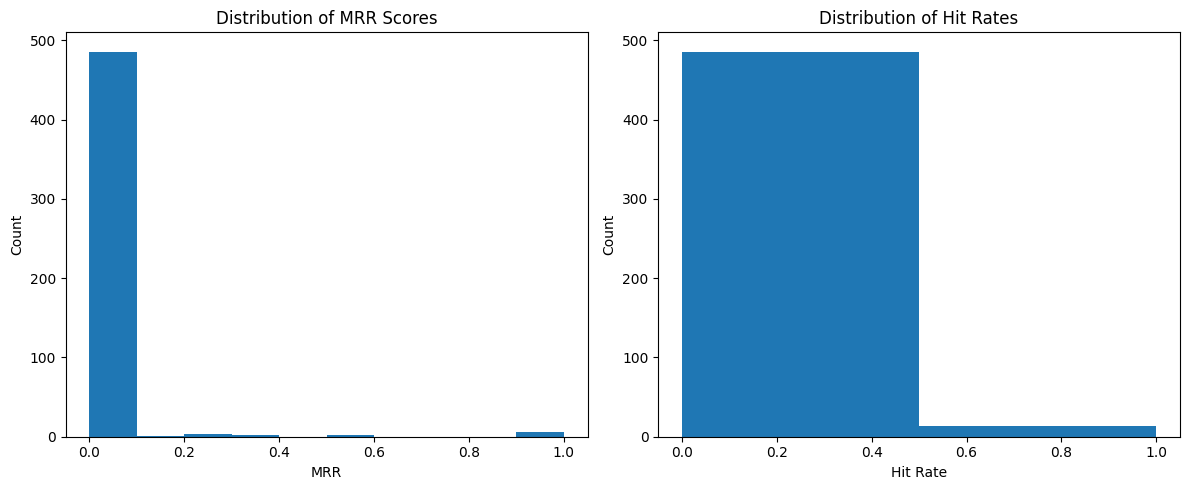

Mean MRR: 0.0170
Mean Hit Rate @ 5: 0.0280


In [11]:
def calculate_mrr(retrieved_chunks, relevant_chunks):
    for i, chunk in enumerate(retrieved_chunks, 1):
        if any(relevant in chunk['content'] for relevant in relevant_chunks):
            return 1 / i
    return 0

def calculate_hit_rate(retrieved_chunks, relevant_chunks, k=7):
    for chunk in retrieved_chunks[:k]:
        if any(relevant in chunk['content'] for relevant in relevant_chunks):
            return 1
    return 0

def evaluate_retrieval():
    eval_pairs = prepare_evaluation_dataset(500) # Limit to 500 for faster evaluation
    mrr_scores = []
    hit_rates = []
    
    for pair in tqdm(eval_pairs, desc="Evaluating"):
        results = elastic_search_hybrid1(pair['question'])
        retrieved_chunks = [hit['_source'] for hit in results['hits']['hits']]
        
        mrr = calculate_mrr(retrieved_chunks, pair['relevant_chunks'])
        hit_rate = calculate_hit_rate(retrieved_chunks, pair['relevant_chunks'])
        
        mrr_scores.append(mrr)
        hit_rates.append(hit_rate)
    
    return {
        'mean_mrr': np.mean(mrr_scores),
        'mean_hit_rate': np.mean(hit_rates),
        'mrr_scores': mrr_scores,
        'hit_rates': hit_rates
    }

# Run evaluation
results = evaluate_retrieval()

# Visualize results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(results['mrr_scores'], bins=10)
plt.title('Distribution of MRR Scores')
plt.xlabel('MRR')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(results['hit_rates'], bins=2)
plt.title('Distribution of Hit Rates')
plt.xlabel('Hit Rate')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"Mean MRR: {results['mean_mrr']:.4f}")
print(f"Mean Hit Rate @ 5: {results['mean_hit_rate']:.4f}")

I think such a low result may be related not only to the quality of the answers, but above all to the fact that we did not index the entire dataset (many questions from the dataset cannot be answered by definition).
I also tested this by vectorizing more chunks of the dataset, which increased the mrr by 0.6%.

### Evaluate query 2

In [36]:
def evaluate_retrieval2():
    eval_pairs = prepare_evaluation_dataset(500)
    mrr_scores = []
    hit_rates = []
    
    for pair in tqdm(eval_pairs, desc="Evaluating"):
        results = elastic_search_hybrid2(pair['question'])
        retrieved_chunks = [hit['_source'] for hit in results['hits']['hits']]
        
        mrr = calculate_mrr(retrieved_chunks, pair['relevant_chunks'])
        hit_rate = calculate_hit_rate(retrieved_chunks, pair['relevant_chunks'])
        
        mrr_scores.append(mrr)
        hit_rates.append(hit_rate)
    
    return {
        'mean_mrr': np.mean(mrr_scores),
        'mean_hit_rate': np.mean(hit_rates),
        'mrr_scores': mrr_scores,
        'hit_rates': hit_rates
    }

Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]

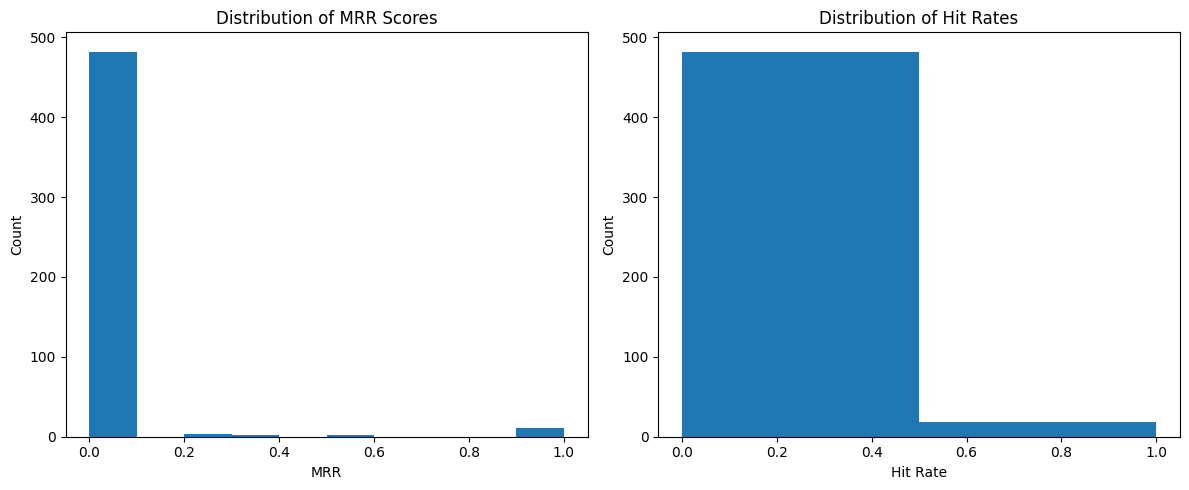

Mean MRR: 0.0266
Mean Hit Rate @ 5: 0.0360


In [37]:
# Run evaluation
results = evaluate_retrieval2()

# Visualize results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(results['mrr_scores'], bins=10)
plt.title('Distribution of MRR Scores')
plt.xlabel('MRR')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(results['hit_rates'], bins=2)
plt.title('Distribution of Hit Rates')
plt.xlabel('Hit Rate')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"Mean MRR: {results['mean_mrr']:.4f}")
print(f"Mean Hit Rate @ 5: {results['mean_hit_rate']:.4f}")

This query definitely faster, MRR and MHR are better.
`TODO:` change embedding model to smaller dims to speed up the application..

# LLM using (Groq), RAG flow

Register in Groq, get API_KEY, set it to .env file:

```
GROQ_API_KEY=<your-api-key-here>
```

In [26]:
from groq import Groq

GROQ_API_KEY="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"#os.getenv('GROQ_API_KEY')

client = Groq(
    api_key=GROQ_API_KEY,
)

### check if context is too high for this model (8192 tokens), then summarize or trim

In [21]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def is_tokens_exceed_the_limit(text, max_tokens=8192):
    tokens = tokenizer(text)
    token_count = len(tokens['input_ids'])

    if token_count > max_tokens:
        print(f"Token count ({token_count}) exceeds the {max_tokens}-token limit! Trimming the text.")
        trimmed_text = tokenizer.decode(tokens['input_ids'][:max_tokens], skip_special_tokens=True)
        return True, trimmed_text  
    else:
        print(f"Token count ({token_count}) is within the {max_tokens}-token limit.")
        return False, text 

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`todo` this summarizer is very slow (i checked). i will not use it 

```python
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

tokenizer = AutoTokenizer.from_pretrained("google/long-t5-tglobal-base")
summarize_model = AutoModelForSeq2SeqLM.from_pretrained("google/long-t5-tglobal-base")

def summarize_text(text):
    summarizer = pipeline("summarization", model=summarize_model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)
    chunks = split_text(text, tokenizer, max_tokens=4096)

    summaries = []
    for chunk in chunks:
        summary = summarizer(chunk, max_length=200, min_length=50, do_sample=False)
        summaries.append(summary[0]['summary_text'])

    return ' '.join(summaries)

def split_text(text, tokenizer, max_tokens=4096):
    tokens = tokenizer(text, return_tensors='pt', truncation=False)['input_ids'][0]
    chunks = []

    # Разбиваем на чанки по max_tokens
    for i in range(0, len(tokens), max_tokens):
        chunk_tokens = tokens[i:i + max_tokens]
        chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
        chunks.append(chunk_text)

    return chunks
```

In [12]:
def build_prompt(query, search_results):
    prompt_template = """
You are an intellectual assistant specializing in philosophy. Your task is to help users find and interpret philosophical concepts and ideas using information from the provided texts. 

Answer the QUESTION based on the CONTEXT from the philosophy database.

While give a response, be consider:
* Be based only(!) on CONTEXT, if context isn't EMPTY. Else tell that you have no answer.
* Provide a response that is understandable and recreates the historical, intellectual, or social context in which the concept was created if the question concerns a concept. 
* If the question concerns a thinker, describe their general teaching, core ideas, and influence on philosophy.
* Give an example if you have some.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()
    
    context = ""
    for hit in search_results['hits']['hits']:
        context += f"{hit['_source']['content']}\n"
        
    # check if context is too high for this model (8192 tokens), then summarize
    exceeds, processed_text = is_tokens_exceed_the_limit(context)
    if exceeds:
        context = processed_text
    prompt = prompt_template.format(question=query, context=context if context else "EMPTY").strip()
   # print(prompt)
    return prompt

def llm(prompt):
    response = client.chat.completions.create(
    messages=[{"role": "user", "content": prompt,}], model="llama3-8b-8192",)
    return response.choices[0].message.content

def rag(query):
    search_results = elastic_search_hybrid2(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

# Ask question here:

In [40]:
rag("tell me what is abduction?")

Token count (4983) is within the 8192-token limit.
You are an intellectual assistant specializing in philosophy. Your task is to help users find and interpret philosophical concepts and ideas using information from the provided texts. 

Answer the QUESTION based on the CONTEXT from the philosophy database.

While give a response, be consider:
* Be based only(!) on CONTEXT, if context isn't EMPTY. Else tell that you have no answer.
* Provide a response that is understandable and recreates the historical, intellectual, or social context in which the concept was created if the question concerns a concept. 
* If the question concerns a thinker, describe their general teaching, core ideas, and influence on philosophy.
* Give an example if you have some.

QUESTION: tell me what is abduction?

CONTEXT: 

In textbooks on epistemology or the philosophy of science, one often
encounters something like the following as a formulation of
abduction:

You happen to know that Tim and Harry have recentl

'What a delightful question! \n\nAbduction, in the context of epistemology and philosophy of science, refers to the process of forming an explanation or hypothesis based on incomplete or unclear evidence, but in search of the best possible explanation. It involves drawing inferences or making educated guesses from the data, often relying on background knowledge, experience, and prior assumptions. \n\nThe term "abduction" was coined by American philosopher Charles Sanders Peirce in the late 19th century. He differentiated abduction from other forms of reasoning, such as deduction (drawing logical conclusions from established premises) and induction (making general claims based on specific observations).\n\nIn the text you provided, abduction is discussed in the context of scientific methodology, particularly in the discovery of the planet Neptune and the concept of cathode rays. The idea is that scientists use abduction to fill in the gaps in their knowledge, making educated guesses abo

In [54]:
rag("who is gilles deleuze?")

{'took': 4, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}}
You are an intellectual assistant specializing in philosophy. Your task is to help users find and interpret philosophical concepts and ideas using information from the provided texts. 

Answer the QUESTION based on the CONTEXT from the philosophy database.

While give a response, be consider:
* Be based only(!) on CONTEXT, if context isn't empty.
* Provide a response that is understandable and recreates the historical, intellectual, or social context in which the concept was created if the question concerns a concept. 
* If the question concerns a thinker, describe their general teaching, core ideas, and influence on philosophy.
* Give an example if you have some.

QUESTION: who is gilles deleuze?

CONTEXT:


'A fascinating question! Based on the context, I\'m assuming you\'re asking about Gilles Deleuze, a French philosopher known for his unique and influential ideas.\n\nGilles Deleuze (1925-1995) was a French philosopher who primarily focused on the fields of metaphysics, epistemology, and philosophy of language. He is best known for his concept of "becoming" and his critique of traditional notions of identity, subjectivity, and reality.\n\nDeleuze\'s philosophy can be characterized by several key concepts, including:\n\n1. **Becoming**: Deleuze argues that reality is in a constant state of flux, and that things are constantly changing and becoming something else. He rejects the idea of fixed essences and instead emphasizes the dynamic, relational nature of reality.\n2. **Desire**: Deleuze sees desire as a fundamental force that drives change and becoming. He argues that desire is not something that can be satisfied, as it is constantly propelled by a sense of lack or desire for more.\n3.

*You can see that there is no information about Gilles Deleuze in the CONTEXT (in index), and we asked in the prompt to base it only on the context, but LLM still responds. That's not really good.*

So I had to rewrite prompt to CONTEXT = EMPTY, if index has no results.

In [58]:
rag("who is gilles deleuze?")

You are an intellectual assistant specializing in philosophy. Your task is to help users find and interpret philosophical concepts and ideas using information from the provided texts. 

Answer the QUESTION based on the CONTEXT from the philosophy database.

While give a response, be consider:
* Be based only(!) on CONTEXT, if context isn't EMPTY. Else tell that you have no answer.
* Provide a response that is understandable and recreates the historical, intellectual, or social context in which the concept was created if the question concerns a concept. 
* If the question concerns a thinker, describe their general teaching, core ideas, and influence on philosophy.
* Give an example if you have some.

QUESTION: who is gilles deleuze?

CONTEXT: 
EMPTY


'Since the context is empty, I don\'t have any specific information to work with. However, I can provide some general information about Gilles Deleuze.\n\nGilles Deleuze (1925-1995) was a French philosopher who is widely regarded as one of the most important and influential thinkers of the 20th century. He was a key figure in the development of poststructuralism and postmodern thought, and his work has had a significant impact on many fields, including philosophy, sociology, cultural studies, and art theory.\n\nDeleuze\'s philosophy is characterized by a number of key concepts and ideas, including:\n\n1. Anti-essentialism: Deleuze is critical of traditional notions of essentialism, which he sees as being based on the idea that things have a fixed and unchanging essence or identity.\n2. Difference: Deleuze argues that difference is a fundamental aspect of reality, and that it is the driving force behind all change and evolution.\n3. Rhizome: Deleuze and his collaborator Félix Guattari u

*Okay...*

# Offline RAG Evaluation

## Cosine similarity 

cosine similarity of embeddings: `ground_truth_dataset answers` VS `llm answers based on context`

In [104]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import os

class RAGEvaluator:
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)
        self.processed_questions = set()

    def get_llm_response(self, question):
        return rag(question)

    def compute_cosine_similarity(self, llm_response, gt_response):
        llm_embedding = self.model.encode([llm_response])
        gt_embedding = self.model.encode([gt_response])
        similarity_score = cosine_similarity(llm_embedding, gt_embedding)[0][0]
        return similarity_score

    def evaluate(self, gt_questions, gt_responses, output_csv='../data/evaluation_results.csv'):
        
        for i, question in tqdm(enumerate(gt_questions)):
            # Пропускаем уже обработанные вопросы
            if question in self.processed_questions:
                continue

            llm_response = self.get_llm_response(question)
            similarity_score = self.compute_cosine_similarity(llm_response, gt_responses[i])
            
            result_df = pd.DataFrame([{
                'question': question,
                'gt_response': gt_responses[i],
                'llm_response': llm_response,
                'similarity_score': similarity_score
            }])
            result_df.to_csv(output_csv, mode='a', header=False, index=False)
            self.processed_questions.add(question)
        print("Evaluation completed and results saved.")

# Пример использования
evaluator = RAGEvaluator()
# Prepare ground truth dataset
gt_pairs = prepare_evaluation_dataset(50)[25:]
gt_questions = [pair['question'] for pair in gt_pairs]
gt_responses = [pair['relevant_chunks'][0] for pair in gt_pairs]

evaluator.evaluate(gt_questions, gt_responses)

/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
0it [00:00, ?it/s]

Token count (12070) exceeds the 8192-token limit! Trimming the text.


1it [00:03,  3.06s/it]

Token count (12070) exceeds the 8192-token limit! Trimming the text.


2it [00:05,  2.92s/it]

Token count (12070) exceeds the 8192-token limit! Trimming the text.


3it [00:19,  7.61s/it]

Token count (12070) exceeds the 8192-token limit! Trimming the text.


4it [00:35, 11.09s/it]

Token count (12070) exceeds the 8192-token limit! Trimming the text.


5it [00:51, 12.98s/it]

Token count (12070) exceeds the 8192-token limit! Trimming the text.


6it [01:09, 14.45s/it]

Token count (0) is within the 8192-token limit.


7it [01:10, 10.05s/it]

Token count (349) is within the 8192-token limit.


8it [01:12,  7.51s/it]

Token count (3314) is within the 8192-token limit.


9it [01:16,  6.49s/it]

Token count (5249) is within the 8192-token limit.


10it [01:29,  8.37s/it]

Token count (6005) is within the 8192-token limit.


11it [01:41,  9.61s/it]

Token count (4856) is within the 8192-token limit.


12it [01:50,  9.55s/it]

Token count (4960) is within the 8192-token limit.


13it [02:02, 10.18s/it]

Token count (5220) is within the 8192-token limit.


14it [02:13, 10.31s/it]

Token count (3218) is within the 8192-token limit.


15it [02:20,  9.41s/it]

Token count (6343) is within the 8192-token limit.


16it [02:34, 10.73s/it]

Token count (4293) is within the 8192-token limit.


17it [02:43, 10.35s/it]

Token count (5451) is within the 8192-token limit.


18it [02:55, 10.74s/it]

Token count (2871) is within the 8192-token limit.


19it [03:01,  9.32s/it]

Token count (3035) is within the 8192-token limit.


20it [03:08,  8.75s/it]

Token count (3421) is within the 8192-token limit.


21it [03:17,  8.62s/it]

Token count (4572) is within the 8192-token limit.


22it [03:27,  9.25s/it]

Token count (4989) is within the 8192-token limit.


23it [03:39,  9.92s/it]

Token count (1678) is within the 8192-token limit.


24it [03:42,  7.96s/it]

Token count (3550) is within the 8192-token limit.


25it [03:50,  9.24s/it]

Evaluation completed and results saved.


### Results for cosine similarity 

In [111]:
import pandas as pd

df = pd.read_csv('../data/evaluation_results.csv')
df['similarity_score'].describe()

count    49.000000
mean      0.612356
std       0.138670
min       0.060956
25%       0.556567
50%       0.656393
75%       0.696515
max       0.835106
Name: similarity_score, dtype: float64

# Online RAG Evaluation (user feedback)

In [29]:
question = "give me general concept about what is abduction"
answer = rag(question)
answer

Token indices sequence length is longer than the specified maximum sequence length for this model (3519 > 1024). Running this sequence through the model will result in indexing errors


Token count (3519) is within the 8192-token limit.


'Based on the provided context, I can explain the concept of abduction in the context of epistemology and the philosophy of science.\n\nAbduction is a type of reasoning that is often used in everyday life, science, and philosophy. It involves making an educated guess or inference from incomplete or insufficient information. In other words, abduction is a form of reasoning that involves proposing an explanation for an observed phenomenon based on available data, even if the data is not sufficient to logically prove the explanation.\n\nThe term "abduction" comes from the philosophy of science, where it is often used to describe the process of scientists proposing hypotheses or explanations for observed phenomena, even when the data is not yet comprehensive or conclusive. In this context, abduction is seen as a crucial step in the scientific method, allowing scientists to make educated guesses and test them against further evidence.\n\nIn the example provided, the author illustrates abduc

In [48]:
# save to elastic
from datetime import datetime

def save_feedback(rating):
    #create document for evaluation
    document = {
        'question': question,
        'response': answer,
        'rating': rating,
        'timestamp': datetime.now()
    }
    # Сохранение документа в индекс
    print(es_client.index(index='response_ratings', body=document))

In [46]:
rating = 0

def upvote():
    global rating
    rating = 1
    save_feedback(rating)
    
def downvote():
    global rating
    rating = -1
    save_feedback(rating)

### Write feedback here: write `upvote()` or `downvote()`:

In [53]:
upvote()
rating

{'_index': 'response_ratings', '_id': '2M6VbpIBSno6HdkhfvjV', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 2, 'failed': 0}, '_seq_no': 4, '_primary_term': 1}


1

In [52]:
downvote()
rating

{'_index': 'response_ratings', '_id': 'r-2UbpIBW1rLOQO2_thq', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 2, 'failed': 0}, '_seq_no': 3, '_primary_term': 1}


-1